In [1]:
%matplotlib inline

# Torch
import torch
from torch.utils.data import DataLoader
from torch import optim, nn

# Custom
import data
import model
import utils

In [2]:
"""
Data Split for First Layer classification task (normal vs infected) 
"""

fl_labels = {
0 : "Normal",
1 : "Infected"
}

fl_train = data.Lung_Dataset('train', verbose = 0)
fl_test = data.Lung_Dataset('test', verbose = 0)
fl_val = data.Lung_Dataset('val', verbose = 0)

"""
Data Split for Second Layer classification task (COVID vs Non-COVID) 
"""

sl_labels = {
0 : "COVID",
1 : "Non-COVID"
}

sl_train = data.Lung_Dataset('train', verbose = 2)
sl_test = data.Lung_Dataset('test', verbose = 2)
sl_val = data.Lung_Dataset('val', verbose = 2)

"""
Data Split for combined classification task (normal vs COVID vs Non-COVID) 
"""

combined_labels = {
0 : "Normal",
1 : "COVID",
2 : "Non-COVID"
}

final_val = data.Lung_Dataset('val', verbose = 1)
final_test = data.Lung_Dataset('test', verbose = 1)

Training the first model to classify normal and infected images
Epoch 1


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.6752270460128784
Validation set accuracy:  76.0 %

Epoch 2


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.47357872128486633
Validation set accuracy:  80.0 %

Epoch 3


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.7132768034934998
Validation set accuracy:  80.0 %

Epoch 4


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.26196369528770447
Validation set accuracy:  92.0 %

Epoch 5


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.3928426504135132
Validation set accuracy:  88.0 %

Epoch 6


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.15897126495838165
Validation set accuracy:  92.0 %

Epoch 7


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.816957414150238
Validation set accuracy:  80.0 %

Epoch 8


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.11424663662910461
Validation set accuracy:  92.0 %

Epoch 9


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.5434139966964722
Validation set accuracy:  80.0 %

Epoch 10


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.11999873071908951
Validation set accuracy:  92.0 %

Epoch 11


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.4343123733997345
Validation set accuracy:  88.0 %

Epoch 12


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.9960086941719055
Validation set accuracy:  72.0 %

Epoch 13


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.3625272512435913
Validation set accuracy:  88.0 %

Epoch 14


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.0428384430706501
Validation set accuracy:  100.0 %

Epoch 15


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.04274778813123703
Validation set accuracy:  96.0 %

Epoch 16


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.23040656745433807
Validation set accuracy:  88.0 %

Epoch 17


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.11329092085361481
Validation set accuracy:  92.0 %

Epoch 18


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.08750941604375839
Validation set accuracy:  96.0 %

Epoch 19


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.106974296271801
Validation set accuracy:  92.0 %

Epoch 20


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.13728350400924683
Validation set accuracy:  92.0 %

Epoch 21


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.2692308723926544
Validation set accuracy:  92.0 %

Epoch 22


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.2591690421104431
Validation set accuracy:  92.0 %

Epoch 23


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.23158113658428192
Validation set accuracy:  92.0 %

Epoch 24


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.7509890794754028
Validation set accuracy:  84.0 %

Epoch 25


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.043663140386343
Validation set accuracy:  96.0 %




Test Accuracy of the first model:
Test set accuracy:  81.78861788617886 %



Training the second model to classify COVID and non-COVID images
Epoch 1


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.9835726618766785
Validation set accuracy:  29.41176470588235 %

Epoch 2


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.891079843044281
Validation set accuracy:  47.05882352941177 %

Epoch 3


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 1.1014273166656494
Validation set accuracy:  58.8235294117647 %

Epoch 4


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.79659503698349
Validation set accuracy:  58.8235294117647 %

Epoch 5


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8713027238845825
Validation set accuracy:  52.94117647058823 %

Epoch 6


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8800028562545776
Validation set accuracy:  41.1764705882353 %

Epoch 7


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8831477165222168
Validation set accuracy:  47.05882352941177 %

Epoch 8


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 1.0119612216949463
Validation set accuracy:  29.41176470588235 %

Epoch 9


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.952667236328125
Validation set accuracy:  35.294117647058826 %

Epoch 10


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.9184274673461914
Validation set accuracy:  76.47058823529412 %

Epoch 11


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8837293386459351
Validation set accuracy:  58.8235294117647 %

Epoch 12


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 1.0635976791381836
Validation set accuracy:  58.8235294117647 %

Epoch 13


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8750876188278198
Validation set accuracy:  64.70588235294117 %

Epoch 14


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 1.3079668283462524
Validation set accuracy:  58.8235294117647 %




Test Accuracy of the second model:
Test set accuracy:  92.6509186351706 %
Test set accuracy:  68.0 %
Validation Set Results


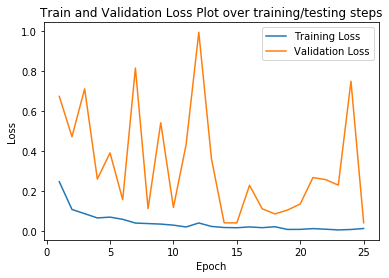

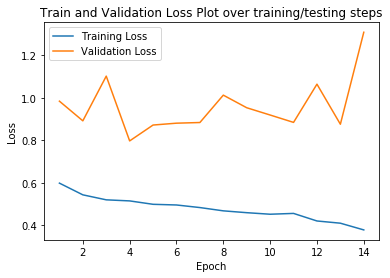

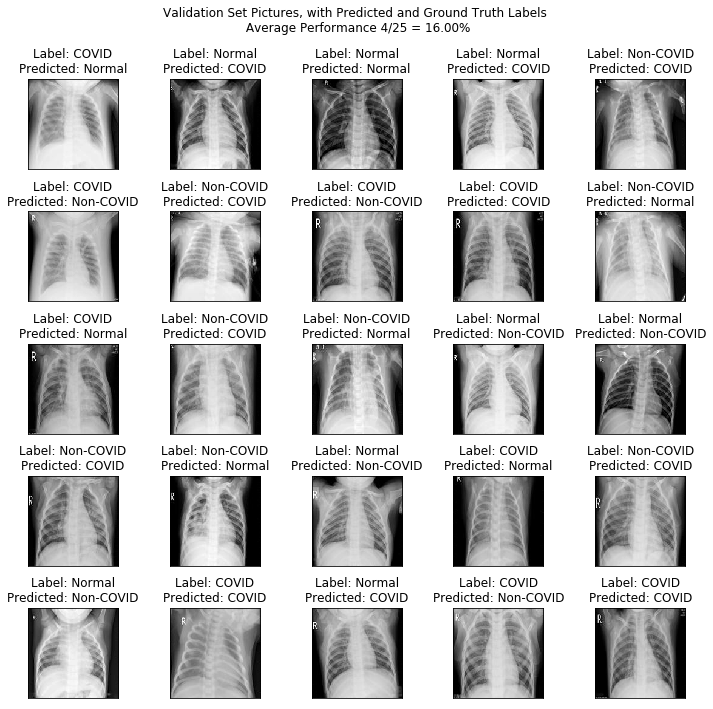

In [3]:
def main():
    N_EPOCH = 200
    L_RATE = 0.001
    BATCH_SIZE = 32
    PATIENCE = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #First Model Training
    fl_train_loader = DataLoader(fl_train, batch_size=BATCH_SIZE, shuffle=True)
    fl_val_loader = DataLoader(fl_val, batch_size=BATCH_SIZE, shuffle=True)
    fl_test_loader = DataLoader(fl_test, batch_size=BATCH_SIZE, shuffle=True)
    
    fl_model = model.CNN().to(device)
    fl_optimizer = optim.Adam(fl_model.parameters(), lr=L_RATE)
    
    print("Training the first model to classify normal and infected images")
    model.train(fl_model, device, nn.BCELoss(), fl_optimizer, fl_train_loader, fl_val_loader, N_EPOCH, PATIENCE, "fl")

    print("\n\n")
    print("Test Accuracy of the first model:")
    model.test(fl_model, device, fl_test_loader)

    fl_model.to("cpu")
    
    model.save_model(fl_model, fl_optimizer, './saved_models/fl_model.pth')
    
    #Second Model Training
    sl_train_loader = DataLoader(sl_train, batch_size=BATCH_SIZE, shuffle=True)
    sl_val_loader = DataLoader(sl_val, batch_size=BATCH_SIZE, shuffle=True)
    sl_test_loader = DataLoader(sl_test, batch_size=BATCH_SIZE, shuffle=True)
    
    sl_model = model.CNN().to(device)
    
    sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE)
    
    print("\n\n")
    print("Training the second model to classify COVID and non-COVID images")
    model.train(sl_model, device, nn.BCELoss(), sl_optimizer, sl_train_loader, sl_val_loader, N_EPOCH, PATIENCE, "sl")
    
    print("\n\n")
    print("Test Accuracy of the second model:")
    model.test(sl_model, device, sl_test_loader)
    
    sl_model.to("cpu")
    
    model.save_model(sl_model, sl_optimizer, './saved_models/sl_model.pth')
    
    #Combine the 2 Models
    final_val_loader = DataLoader(final_val, batch_size=32, shuffle=True)
    final_test_loader = DataLoader(final_test, batch_size=32, shuffle=True)
    
    combined_model = model.combine_models('./saved_models/fl_model.pth','./saved_models/sl_model.pth',device,L_RATE)
    print('\n\n')
    print('Testing Combined Model \n')
    pred = combined_model.test_combine(device, final_val_loader, print_acc=True, return_results = True)
    
    print("Validation Set Results")
    utils.generate_performance_display(final_val_loader, pred,combined_labels)
    
if __name__ == '__main__':
    main()

In [4]:
# """
# Soo Han's own testing code. can delete away
# """

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# L_RATE = 0.001

# fl_model = model.CNN().to(device)
# fl_optimizer = optim.Adam(fl_model.parameters(), lr=L_RATE)
# fl_model, fl_optimizer = model.load_model(fl_model, fl_optimizer, './saved_models/fl_model.pth',device)

# sl_model = model.CNN().to(device)
# sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE)
# sl_model, sl_optimizer = model.load_model(sl_model, sl_optimizer, './saved_models/sl_model.pth',device)

# # fl_test_loader = DataLoader(fl_test, batch_size=32, shuffle=True)
# # sl_test_loader = DataLoader(sl_test, batch_size=32, shuffle=True)
# final_test_loader = DataLoader(final_test, batch_size=32, shuffle=True)
# final_val_loader = DataLoader(final_val, batch_size=32, shuffle=True)

# # sl_model.eval()
# # model.test(sl_model, device, sl_test_loader)

In [5]:
# combined_model = model.combine_models('./saved_models/fl_model.pth','./saved_models/sl_model.pth',device,L_RATE)
# #combined_model.test_combine(device, final_test_loader, print_acc = True)

In [6]:
# pred = combined_model.test_combine(device, final_val_loader, return_results = True)
# utils.generate_performance_display(final_val_loader, pred,combined_labels )